In [25]:
suppressMessages(library(tidyverse))
suppressMessages(library(glue))
suppressMessages(library(data.table))

In [46]:
suppressMessages(library(cowplot))
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res = 180)
theme_set(theme_cowplot())

## u-sQTL vs. s-sQTLs across tissues 

In [27]:
setwd("~/cdai/SpliFi/analysis")

In [28]:
suppressMessages(library(furrr))
plan(multisession, workers = 6)

In [29]:
gtex_sqtl_files <- list.files(path = "../data/CategorizeSplicingQTLs/GTEx", pattern = "*.tsv", full.names = TRUE)

In [30]:
names(gtex_sqtl_files) <- str_split(gtex_sqtl_files, "/") %>% map_chr(5) %>% 
    str_remove("\\.tsv")

In [31]:
gtex_sqtl_files %>% str()

 Named chr [1:49] "../data/CategorizeSplicingQTLs/GTEx/Adipose-Subcutaneous.tsv" ...
 - attr(*, "names")= chr [1:49] "Adipose-Subcutaneous" "Adipose-Visceral_Omentum_" "AdrenalGland" "Artery-Aorta" ...


In [32]:
calcSqtlSplit <- function(df) {
    # compute u-sQTL and p-sQTL split for each tissue
    df[, .N, by = qtl_cl][, .(qtl_cl, N, p = N/sum(N))]
}

In [33]:
sqtl_split <- map(gtex_sqtl_files, \(x)
    fread(x) %>% calcSqtlSplit()
    )
# add tissue name to a column, then rbind
sqtl_split <- imap_dfr(sqtl_split, \(x, y) {
    x[, tissue := y][]
})

In [35]:
sqtl_split[1:5]

qtl_cl,N,p,tissue
<chr>,<int>,<dbl>,<chr>
u-sQTL,3097,0.3945223,Adipose-Subcutaneous
p-sQTL,4753,0.6054777,Adipose-Subcutaneous
p-sQTL,3951,0.6056101,Adipose-Visceral_Omentum_
u-sQTL,2573,0.3943899,Adipose-Visceral_Omentum_
u-sQTL,1404,0.3704485,AdrenalGland


In [56]:
N_sqtl_medians = sqtl_split[, .(N = sum(N)), by = .(tissue, qtl_cl)][, .(medianN = median(N)), by = qtl_cl] %>% deframe
N_sqtl_medians

u-sQTL p-sQTL 
  1497   2440

In [70]:
N_sqtl_medians["p-sQTL"] %>% str

 Named num 2440
 - attr(*, "names")= chr "p-sQTL"


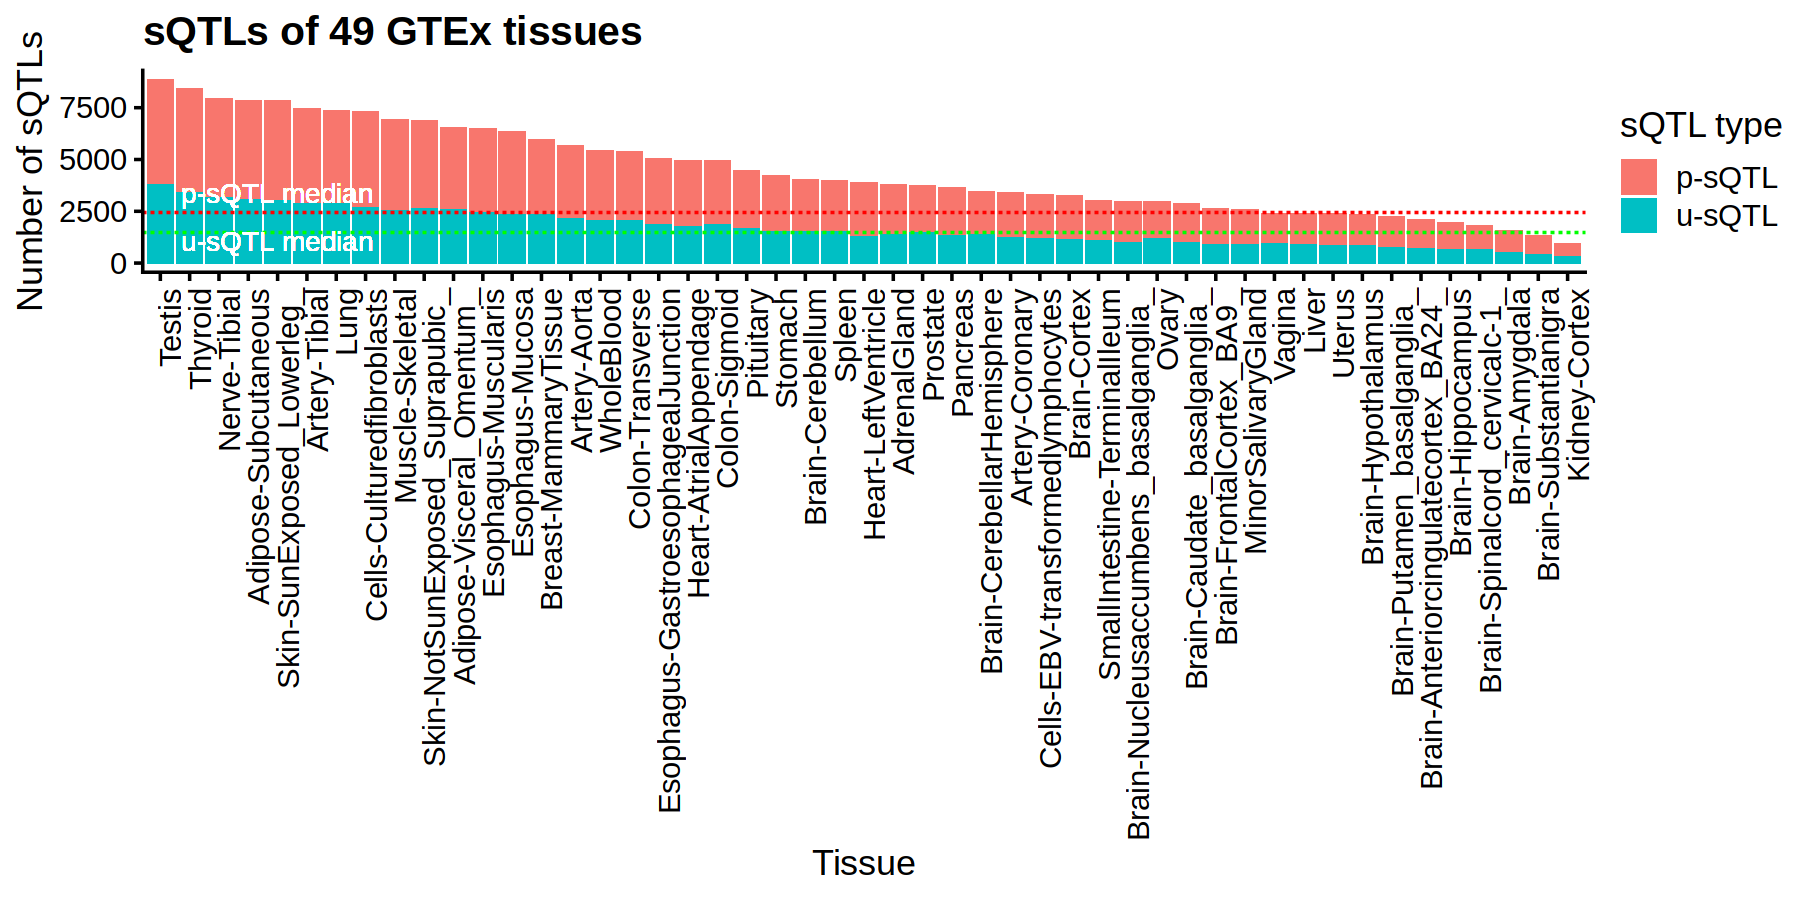

In [80]:
sqtl_split %>% 
    ggplot() + geom_col(aes(x = forcats::fct_reorder(tissue, N, .fun = sum, .desc = T), y = N, fill = qtl_cl)) +
        geom_hline(yintercept = N_sqtl_medians["p-sQTL"], linetype = "dashed", color = "red") +
        geom_hline(yintercept = N_sqtl_medians["u-sQTL"], linetype = "dashed", color = "green") +
        geom_text(aes(x = 5, y = N_sqtl_medians["p-sQTL"], label = "p-sQTL median"), vjust = -.5, color = "white") +
        geom_text(aes(x = 5, y = N_sqtl_medians["u-sQTL"], label = "u-sQTL median"), vjust = 1, color = "white") +
        labs(x = "Tissue", y = "Number of sQTLs", fill = "sQTL type", title = "sQTLs of 49 GTEx tissues") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [91]:
p_uSqtl <- sqtl_split[qtl_cl == 'u-sQTL', p] %>% median
p_uSqtl

[1] 0.38013

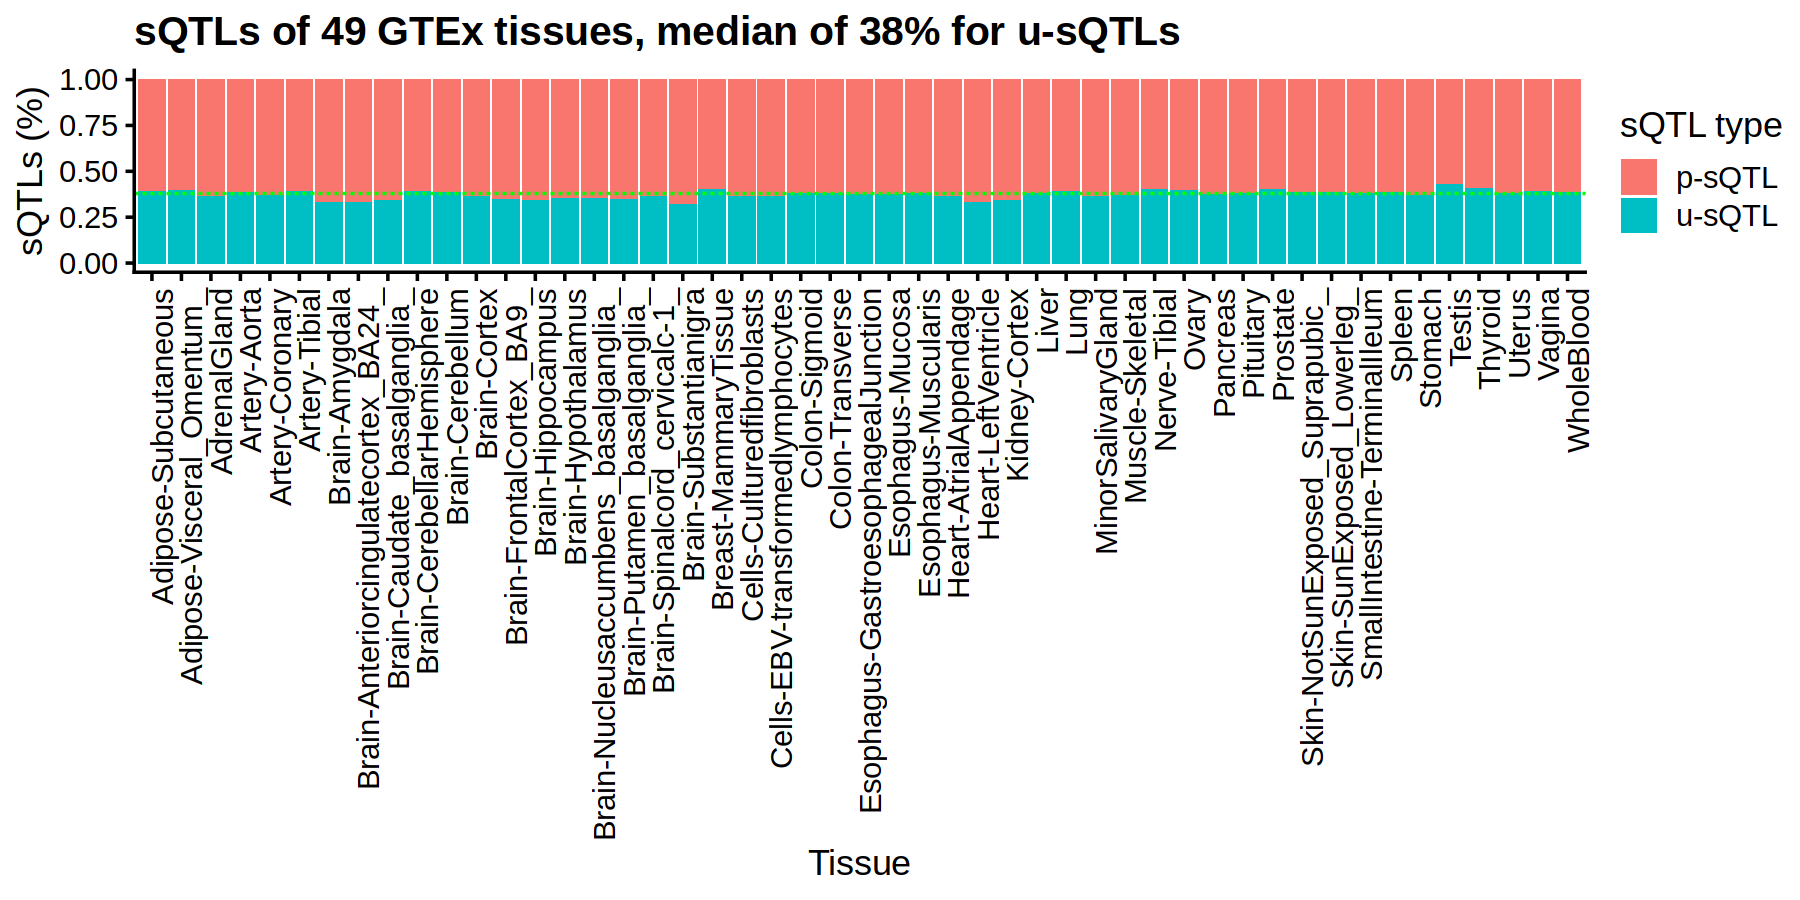

In [93]:
sqtl_split %>%
    ggplot() + geom_col(aes(x = forcats::fct_reorder(tissue, p, .fun = sum, .desc = T), y = p, fill = qtl_cl)) +
        geom_hline(yintercept = p_uSqtl, linetype = "dashed", color = "green") +
        labs(x = "Tissue", y = "sQTLs (%)", fill = "sQTL type", title = glue("sQTLs of 49 GTEx tissues, median of 38% for u-sQTLs")) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1))

## What about Geuvadis EUR?

In [94]:
geu_sqtl_file <- "../data/CategorizeSplicingQTLs/Geuvadis/EUR.tsv"
geu_sqtl_split <- fread(geu_sqtl_file) %>% calcSqtlSplit()

In [95]:
geu_sqtl_split 

qtl_cl,N,p
<chr>,<int>,<dbl>
u-sQTL,3693,0.503065
p-sQTL,3648,0.496935
